In [1]:
import pandas as pd
from great_tables import GT, style, loc
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
from matplotlib.colors import Normalize, LinearSegmentedColormap
import colorsys
from calculate_performance_metrics import compute_metrics
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.utils import resample
from sklearn.metrics import precision_recall_curve, average_precision_score, brier_score_loss

In [2]:
data = pd.read_csv("../../data/test_data_big.csv")
data['race'] = data['race'].replace({
    'White': 'white',
    'Black or African American': 'Non-white',
    'American Indian or Alaska Native': 'Non-white',
    'Asian': 'Non-white',
    'Others': 'Non-white',
    'Not Mentioned': 'Unknown'
})
print(data['race'].unique())

['white' 'Non-white' 'Unknown']


In [3]:
data_balanced = data[data["test_split"] == "global"].reset_index(drop=True)
data_supervised = data[data["test_split"] == "validation_1"].reset_index(drop=True)
data_unsupervised = data[data["test_split"] == "validation_2"].reset_index(drop=True)

In [4]:
balanced_metrics = compute_metrics(data_balanced['pred_score_fusion'], data_balanced['true_label'])
supervised_metrics = compute_metrics(data_supervised['pred_score_fusion'], data_supervised['true_label'])
unsupervised_metrics = compute_metrics(data_unsupervised['pred_score_fusion'], data_unsupervised['true_label'])

In [5]:
balanced_metrics

{'accuracy': 0.8024691358024691,
 'average_precision': 0.8743882200003282,
 'auroc': 0.8731060606060606,
 'f1_score': 0.8383838383838383,
 'weighted_accuracy': 0.7985294117647059,
 'recall': 0.8645833333333334,
 'FPR': 0.2878787878787879,
 'precision': 0.8137254901960784,
 'NPV': 0.7833333333333333,
 'specificity': 0.7121212121212122,
 'accuracy_ci': (0.7405, 0.8624),
 'average_precision_ci': (0.7972, 0.9536),
 'auroc_ci': (0.8108, 0.9329),
 'f1_score_ci': (0.7825, 0.8909),
 'weighted_accuracy_ci': (0.7328, 0.8616),
 'recall_ci': (0.7977, 0.928),
 'FPR_ci': (0.1789, 0.3968),
 'precision_ci': (0.739, 0.8877),
 'NPV_ci': (0.6782, 0.884),
 'specificity_ci': (0.6032, 0.8211),
 'confusion_matrix': {'tn': 47, 'fp': 19, 'fn': 13, 'tp': 83},
 'formatted_accuracy': '80.25 ± 6.1%',
 'formatted_sensitivity': '86.46 ± 6.5%',
 'formatted_specificity': '71.21 ± 10.9%',
 'formatted_ppv': '81.37 ± 7.4%',
 'formatted_npv': '78.33 ± 10.3%',
 'formatted_f1score': '83.84 ± 5.4%',
 'accuracy_err': 0.060950

In [6]:
data_relevant_misclass = data[['participant_id', 'gender', 'age_group', 'race', 'pred_score_fusion', 'true_label']]

In [7]:
stages = pd.read_csv("../../data/df_stage_data.csv")
data_relevant_stage = data[['participant_id', 'gender', 'age_group', 'race', 'pred_score_fusion', 'true_label']]
data_relevant_stage = data_relevant_stage[data_relevant_stage['participant_id'].isin(stages['id'])].reset_index(drop=True)
data_with_stage = data_relevant_stage.merge(stages, left_on='participant_id', right_on='id', how='inner')

# Plot Performance Table

In [8]:
def blend_hex(hex_color: str, frac: float, toward_white: bool = True) -> str:
    frac = frac - (frac - 0.5)*0.7
    r, g, b = mcolors.to_rgb(hex_color)
    r2, g2, b2 = (1,1,1) if toward_white else (0,0,0)
    r_new = r2 + (r - r2) * frac
    g_new = g2 + (g - g2) * frac
    b_new = b2 + (b - b2) * frac
    # print(mcolors.to_hex((r_new, g_new, b_new)))
    return mcolors.to_hex((r_new, g_new, b_new))

def create_performance_table(
    data: dict,
    errors: dict,
    base_colors: list,
    cols_width: int = 100,
    vert_padd: int = 2,
    equal_size: bool = False,
    newline: bool = True,
    title: str = "",
    smooth_corners: bool = False,
    font: str = None,
    bold_headers: bool = False,
    no_grid: bool = False
) -> GT:
    
    # 1) DataFrames
    df = pd.DataFrame(data)
    err_df = pd.DataFrame(errors)
    num_cols = list(df.select_dtypes(include="number").columns)

    # 2) Build text DataFrame
    text_df = df.copy()
    sep = "\n±" if newline else " ± "
    for col in num_cols:
        mean_pct = (df[col] * 100).map(lambda x: f"{x:.1f}%")
        err_pct  = (err_df[col] * 100).map(lambda x: f"{x:.1f}%")
        text_df[col] = mean_pct + sep + err_pct

    # 3) Quantile-based normalization
    num_only = df[num_cols]
    low, high = num_only.quantile(0.05).min(), num_only.quantile(0.95).max()
    norm = Normalize(vmin=low, vmax=high, clip=True)

    # 4) Initialize GT
    gt = GT(text_df, rowname_col="Test Set")

    # 5) Base text styling
    text_style = {'color': 'black', 'align':'center'}
    if font:
        text_style['font'] = font
    if newline:
        text_style['whitespace'] = 'pre-wrap'
    gt = gt.tab_style(style=style.text(**text_style), locations=loc.body())


    # 6) Optional header bolding
    if bold_headers:
        gt = gt.tab_style(style=style.text(weight='bold', align='center'), locations=loc.column_header())
        gt = gt.tab_style(style=style.text(weight='bold', align='center'), locations=loc.stub())

    # 7) Heatmap fill per cell
    for i, base in enumerate(base_colors):
        for col in num_cols:
            val = float(df.at[i, col])
            frac = norm(val)
            cell_hex = blend_hex(base, frac, toward_white=True)
            gt = gt.tab_style(
                style=style.fill(color=cell_hex),
                locations=loc.body(rows=[i], columns=[col])
            )

    # 8) Optional no-grid
    if no_grid:
        gt = gt.tab_style(style=style.borders(sides='all', color='transparent'), locations=loc.body())

    # 9) Optional equal column widths
    if equal_size:
        all_cols = ["Test Set"] + num_cols
        pct_each = f"{cols_width}px"  #f"{100/len(all_cols):.1f}%"
        gt = gt.cols_width(**{col: pct_each for col in all_cols})

    # 10) Optional rounded corners via wrapper CSS hint
    if smooth_corners:

        pass


    gt = gt.opt_vertical_padding(vert_padd)
    
    # 11) Title
    if title:
        gt = gt.tab_header(title=title)


    metric_columns = ["Accuracy", "Specificity", "Sensitivity", "PPV", "NPV", "F1 Score"]

    # some final changes from Saiful
    gt = gt.cols_align(align="center", columns=metric_columns)
    gt = gt.tab_style(
        style=style.text(color="black", weight="bold", size="18px"),
        locations=loc.column_labels()
    )
    gt = gt.tab_style(
        style=style.text(color="blue", size="18px"),
        locations=loc.stub()
    )
    gt=gt.tab_style(
        style=style.text(size="18px"),  # or use '14px', '16pt', etc.
        locations=loc.body()
    )

    return gt

In [9]:
metrics = {
    "Test Set": ["Balanced Test Data ","External Eval. (supervised)","External Eval. (unsupervised)"],
    "Accuracy": [balanced_metrics["accuracy"], supervised_metrics["accuracy"], unsupervised_metrics["accuracy"]],
    "Specificity": [balanced_metrics["specificity"], supervised_metrics["specificity"], unsupervised_metrics["specificity"]],
    "Sensitivity": [balanced_metrics["recall"], supervised_metrics["recall"], unsupervised_metrics["recall"]],
    "PPV": [balanced_metrics["precision"], supervised_metrics["precision"], unsupervised_metrics["precision"]],
    "NPV": [balanced_metrics["NPV"], supervised_metrics["NPV"], unsupervised_metrics["NPV"]],
    "F1 Score": [balanced_metrics["f1_score"], supervised_metrics["f1_score"], unsupervised_metrics["f1_score"]]
}

errors = {
    "Accuracy": [balanced_metrics["accuracy_err"], supervised_metrics["accuracy_err"], unsupervised_metrics["accuracy_err"]],
    "Specificity": [balanced_metrics["specificity_err"], supervised_metrics["specificity_err"], unsupervised_metrics["specificity_err"]],
    "Sensitivity": [balanced_metrics["sensitivity_err"], supervised_metrics["sensitivity_err"], unsupervised_metrics["sensitivity_err"]],
    "PPV": [balanced_metrics["ppv_err"], supervised_metrics["ppv_err"], unsupervised_metrics["ppv_err"]],
    "NPV": [balanced_metrics["npv_err"], supervised_metrics["npv_err"], unsupervised_metrics["npv_err"]],
    "F1 Score": [balanced_metrics["f1score_err"], supervised_metrics["f1score_err"], unsupervised_metrics["f1score_err"]]
}
base_colors = ["#633974", "#1a5276", "#935116"]

gt_table = create_performance_table(
    metrics, errors, base_colors,
    cols_width=130,
    vert_padd=2,
    equal_size=True,
    newline=True,
    # title="Predictive performance of PARK across independent test sets",
    smooth_corners=True,
    font="Roboto, sans-serif",
    bold_headers=False,
    no_grid=True
)
gt_table.save(file="./plots/figure_2/test_sets_performance.png", scale=2)
gt_table.show() 

Accuracy 
 Specificity 
 Sensitivity 
 PPV 
 NPV 
 F1 Score 
 
 
 
 
 Balanced Test Data 
 80.2%
±6.1% 
 71.2%
±10.9% 
 86.5%
±6.5% 
 81.4%
±7.4% 
 78.3%
±10.3% 
 83.8%
±5.4% 
 
 
 External Eval. (supervised) 
 80.2%
±8.0% 
 73.8%
±13.1% 
 85.7%
±9.5% 
 79.2%
±10.7% 
 81.6%
±12.0% 
 82.4%
±7.8% 
 
 
 External Eval. (unsupervised) 
 80.6%
±9.6% 
 78.4%
±13.3% 
 83.3%
±13.6% 
 75.8%
±14.8% 
 85.3%
±12.3% 
 79.4%
±11.4%

# Plot AUROC and AUPRC

In [10]:
def plot_roc_with_ci_ax(
    ax,
    preds,
    labels,
    n_bootstraps=1000,
    seed=None,
    mean_color="#1f77b4",
    chance_color="#7f7f7f",
    ci_color="#c7c7c7",
    ci_alpha=0.2,
    show_legend=True,
):

    if seed is not None:
        np.random.seed(seed)

    # 1) Original ROC & AUC
    fpr, tpr, _ = roc_curve(labels, preds)
    roc_auc = auc(fpr, tpr)

    # 2) Bootstrap TPRs at a common grid
    mean_fpr = np.linspace(0, 1, 200)
    tprs = []
    for _ in range(n_bootstraps):
        idxs = resample(np.arange(len(preds)))
        # skip if only one class present
        if len(np.unique(labels[idxs])) < 2:
            continue
        fpr_b, tpr_b, _ = roc_curve(labels[idxs], preds[idxs])
        tpr_i = np.interp(mean_fpr, fpr_b, tpr_b)
        tpr_i[0] = 0.0
        tprs.append(tpr_i)
    tprs = np.array(tprs)
    b = tprs.shape[0]

    # 3) Compute mean and SE (normal‐approx CI)
    mean_tpr = tprs.mean(axis=0)
    se_tpr   = np.sqrt(((tprs - mean_tpr)**2).sum(axis=0) / (b - 1))
    ci_half  = 1.96 * se_tpr  # for 95%
    lower    = mean_tpr - ci_half
    upper    = mean_tpr + ci_half

    # 4) Plot
    ax.plot(mean_fpr, mean_tpr, color=mean_color, lw=2,
            label=f"Mean (AUC = {roc_auc:.2f})")
    ax.fill_between(mean_fpr, lower, upper,
                    color=ci_color, alpha=ci_alpha,
                    label=f"95% C.I.")
    ax.plot([0, 1], [0, 1], linestyle="--", color=chance_color, lw=1, label="Chance")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xlabel("False Positive Rate", fontsize=20)
    ax.set_ylabel("True Positive Rate", fontsize=20)
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.grid(True, linestyle="--", alpha=0.5)
    if show_legend:
        ax.legend(loc="lower right", fontsize=18)

def plot_multiple_rocs_with_ci(
    preds_list,
    labels_list,
    mean_colors,
    chance_colors,
    ci_colors,
    ci_alpha=0.2,
    n_bootstraps=1000,
    seed=None,
    titles=None,
    figsize=(18, 5),
    show_legend=True,
    show_title=True
):

    n = len(preds_list)
    fig, axes = plt.subplots(1, n, figsize=figsize)
    if n == 1:
        axes = [axes]
    for i, ax in enumerate(axes):
        plot_roc_with_ci_ax(
            ax,
            np.array(preds_list[i]),
            np.array(labels_list[i]),
            n_bootstraps=n_bootstraps,
            seed=seed,
            mean_color=mean_colors[i],
            chance_color=chance_colors[i],
            ci_color=ci_colors[i],
            ci_alpha=ci_alpha,
            show_legend=show_legend
        )
        if show_title and titles:
            ax.set_title(titles[i], fontsize=22, color='blue')
    plt.tight_layout()
    return fig, axes

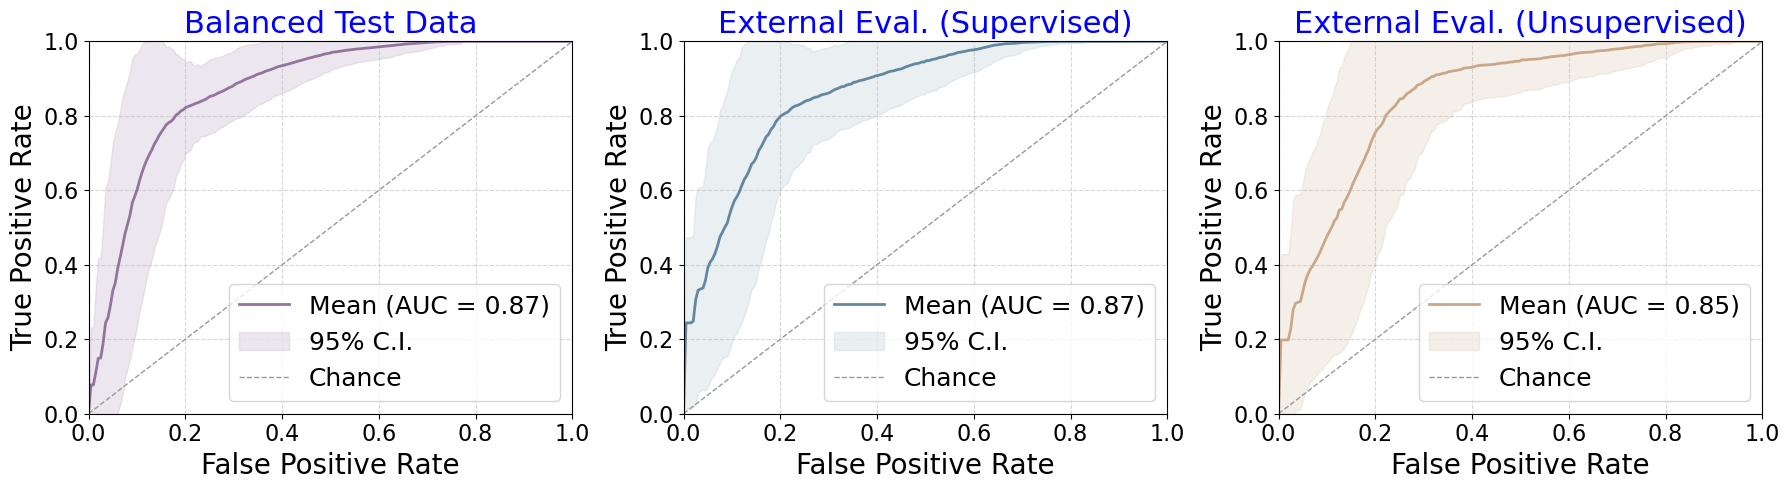

In [11]:
np.random.seed(0)
preds_list = [
    data_balanced['pred_score_fusion'],
    data_supervised['pred_score_fusion'],
    data_unsupervised['pred_score_fusion']
]
labels_list = [
    data_balanced['true_label'],
    data_supervised['true_label'],
    data_unsupervised['true_label']
]
mean_colors = ["#92749e", "#6288a1", "#c9a88a"]
chance_colors = ["#999999"] * 3
ci_colors = ["#c2b1c8", "#bacbd6", "#decab8"]
titles = ["Balanced Test Data", "External Eval. (Supervised)", "External Eval. (Unsupervised)"]

fig, axes = plot_multiple_rocs_with_ci(
    preds_list,
    labels_list,
    mean_colors,
    chance_colors,
    ci_colors,
    ci_alpha=0.3,
    n_bootstraps=300,
    seed=42,
    titles=titles,
    show_legend=True,  
    show_title=True    
)

plt.savefig("plots/figure_2/roc_curves.png", dpi=800, bbox_inches='tight')

plt.show()

In [12]:
def plot_prc_with_ci_ax(
    ax,
    preds,
    labels,
    n_bootstraps=1000,
    seed=None,
    mean_color="#1f77b4",
    chance_color="#7f7f7f",
    ci_color="#c7c7c7",
    ci_alpha=0.2,
    show_legend=True
):

    if seed is not None:
        np.random.seed(seed)

    # 1) Original PRC and average precision
    precision, recall, _ = precision_recall_curve(labels, preds)
    ap = average_precision_score(labels, preds)

    # 2) Bootstrap precision arrays on a fixed recall grid
    mean_recall = np.linspace(0, 1, 200)
    all_prec = []
    for _ in range(n_bootstraps):
        idxs = np.random.choice(len(preds), size=len(preds), replace=True)
        if len(np.unique(labels[idxs])) < 2:
            continue
        p_b, r_b, _ = precision_recall_curve(labels[idxs], preds[idxs])
        # sort r_b, p_b so interpolation is valid
        order = np.argsort(r_b)
        r_b, p_b = r_b[order], p_b[order]
        p_i = np.interp(mean_recall, r_b, p_b, left=p_b[0], right=p_b[-1])
        all_prec.append(p_i)
    all_prec = np.array(all_prec)
    b = all_prec.shape[0]

    # 3) Compute mean + SE → normal‐approx CI
    mean_prec = all_prec.mean(axis=0)
    se_prec   = np.sqrt(((all_prec - mean_prec)**2).sum(axis=0) / (b - 1))
    half_ci   = 1.96 * se_prec
    lower     = mean_prec - half_ci
    upper     = mean_prec + half_ci

    # 4) Plot mean curve + CI band + “chance” line
    ax.plot(mean_recall, mean_prec, color=mean_color, lw=2,
            label=f"Mean (MAP = {ap:.2f})")
    ax.fill_between(mean_recall, lower, upper,
                    color=ci_color, alpha=ci_alpha,
                    label=f"95% C.I.")
    # baseline = prevalence
    pos_rate = np.mean(labels)
    ax.hlines(pos_rate, 0, 1, linestyle='--',
              color=chance_color, lw=1, label="Chance")

    # 5) Formatting
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xlabel("Recall", fontsize=20)
    ax.set_ylabel("Precision", fontsize=20)
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    if show_legend:
        ax.legend(loc="lower left", fontsize=18)

def plot_multiple_prcs_with_ci(
    preds_list,
    labels_list,
    mean_colors,
    chance_colors,
    ci_colors,
    ci_alpha=0.2,
    n_bootstraps=1000,
    seed=None,
    titles=None,
    figsize=(18, 5),
    show_legend=True,
    show_title=True
):
    
    n = len(preds_list)
    fig, axes = plt.subplots(1, n, figsize=figsize)
    if n == 1:
        axes = [axes]
    
    for i, ax in enumerate(axes):
        plot_prc_with_ci_ax(
            ax,
            np.array(preds_list[i]),
            np.array(labels_list[i]),
            n_bootstraps=n_bootstraps,
            seed=seed,
            mean_color=mean_colors[i],
            chance_color=chance_colors[i],
            ci_color=ci_colors[i],
            ci_alpha=ci_alpha,
            show_legend=show_legend
        )
        if show_title and titles:
            ax.set_title(titles[i], fontsize=22, color='blue')
    plt.tight_layout()
    return fig, axes

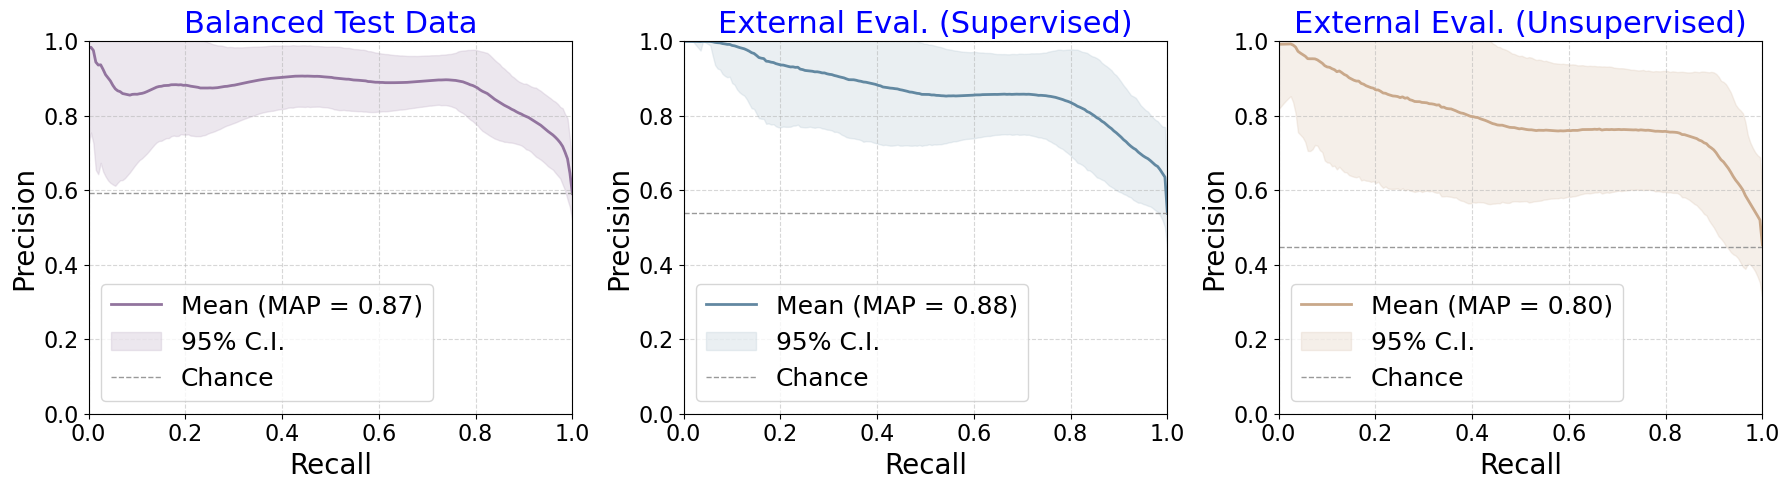

In [13]:
np.random.seed(0)
preds_list = [
    data_balanced['pred_score_fusion'],
    data_supervised['pred_score_fusion'],
    data_unsupervised['pred_score_fusion']
]
labels_list = [
    data_balanced['true_label'],
    data_supervised['true_label'],
    data_unsupervised['true_label']
]

mean_colors   = ["#92749e", "#6288a1", "#c9a88a"]
chance_colors = ["#999999"] * 3
ci_colors     = ["#c2b1c8", "#bacbd6", "#decab8"]
titles        = ["Balanced Test Data", "External Eval. (Supervised)", "External Eval. (Unsupervised)"]

fig, axes = plot_multiple_prcs_with_ci(
    preds_list,
    labels_list,
    mean_colors,
    chance_colors,
    ci_colors,
    ci_alpha=0.3,
    n_bootstraps=500,
    seed=42,
    titles=titles,
    show_legend=True,
    show_title=True
)

plt.savefig("plots/figure_2/pr_curves.png", dpi=800, bbox_inches='tight')
plt.show()

# Plot Calibration Curve

In [14]:
n_bins = 10

In [15]:
def calibration_curve(
    predictions,
    true_labels,
    n_bins=10,
    n_iterations=1000,
    random_state=None
):
    # np.random.seed(random_state)
    bins       = np.linspace(0, 1, n_bins + 1)
    bin_centers= (bins[:-1] + bins[1:]) / 2

    mean_props = []
    lower_ci   = []
    upper_ci   = []

    for i in range(n_bins):
        # Include right edge on last bin
        if i == n_bins - 1:
            in_bin = (predictions >= bins[i]) & (predictions <= bins[i+1])
        else:
            in_bin = (predictions >= bins[i]) & (predictions <  bins[i+1])

        labels_in_bin = true_labels[in_bin]
        if len(labels_in_bin) == 0:
            mean_props.append(np.nan)
            lower_ci.append(np.nan)
            upper_ci.append(np.nan)
            continue

        # Bootstrap the *labels* only
        props = []
        for _ in range(n_iterations):
            sample = resample(
                labels_in_bin,
                replace=True,
                n_samples=len(labels_in_bin),
                random_state=None   # allow true randomness
            )
            props.append(sample.mean())

        props = np.array(props)
        mu = props.mean()

        # # 3) Compute SE with denominator (b - 1)
        # b = len(props)
        # se = np.sqrt(np.sum((props - mu)**2) / (b - 1))

        # # 4) Normal‐approx 95% CI
        # lo = mu - 1.96 * se
        # hi = mu + 1.96 * se
        lo = np.percentile(props, q=2.5)
        hi = np.percentile(props, q=97.5)

        mean_props.append(mu)
        lower_ci.append(lo)
        upper_ci.append(hi)

    return (
      bin_centers,
      np.array(mean_props),
      np.array(lower_ci),
      np.array(upper_ci)
    )

In [16]:
import numpy as np
import matplotlib.pyplot as plt

def plot_calibration_curve_with_ci(
    bin_centers,
    mean_accuracies,
    lower_ci,
    upper_ci,
    ece,
    brier_score,
    cal_color: str = "#2E6930",         
    ci_color: str = "#FF0000",               
    ideal_color: str = "#4C72B0",       
    text_box_facecolor: str = "wheat",  
    text_box_alpha: float = 0.8,        
    figsize: tuple = (8, 6),            
    marker: str = "s"                   
):
    
    # default CI color to match calibration if not provided
    ci_color = ci_color or cal_color

    # 1) Drop empty bins
    mask = ~np.isnan(mean_accuracies)
    bc = bin_centers[mask]
    m  = mean_accuracies[mask]
    lo = lower_ci[mask]
    hi = upper_ci[mask]

    # 2) Build non‐negative error‐bar lengths
    yerr_lower = np.clip(m - lo, 0, None)
    yerr_upper = np.clip(hi - m, 0, None)

    # 3) Start figure
    plt.figure(figsize=figsize)

    # 4) Calibration curve with markers
    plt.plot(
        bc, m,
        marker=marker,
        color=cal_color,
        lw=2,
        label="Calibration curve"
    )

    # 5) Error bars
    plt.errorbar(
        bc, m,
        yerr=[yerr_lower, yerr_upper],
        fmt='none',
        ecolor=ci_color,
        lw=0.5,
        capsize=2,
        label="95% C.I."
    )

    # 6) Ideal diagonal
    plt.plot(
        [0, 1], [0, 1],
        linestyle='--',
        color=ideal_color,
        lw=1,
        label="Ideal calibration"
    )

    # 7) Labels, title, grid
    plt.xlabel('Predicted probability', fontsize=21)
    plt.ylabel('True probabilities in each bin', fontsize=21)
    #plt.title('Calibration Curve with Confidence Intervals')
    #plt.grid(True)

    # 8) Metrics textbox
    #textstr = f'Brier Score: {brier_score:.4f}\nECE: {ece:.4f}'
    textstr = f'Brier Score: {brier_score:.4f}'
    props = dict(boxstyle='round', facecolor=text_box_facecolor, alpha=text_box_alpha)
    plt.text(0.55, 0.05, textstr, fontsize=18, bbox=props)

    # 9) Axis limits & legend
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(loc='best', fontsize=18)
    plt.savefig("plots/figure_2/calibration_curve.png", dpi=800, bbox_inches='tight')
    plt.show()

In [17]:
# combine all preds and labels
preds = np.concatenate([data_balanced['pred_score_fusion'], data_supervised['pred_score_fusion'], data_unsupervised['pred_score_fusion']])
labels = np.concatenate([data_balanced['true_label'], data_supervised['true_label'], data_unsupervised['true_label']])

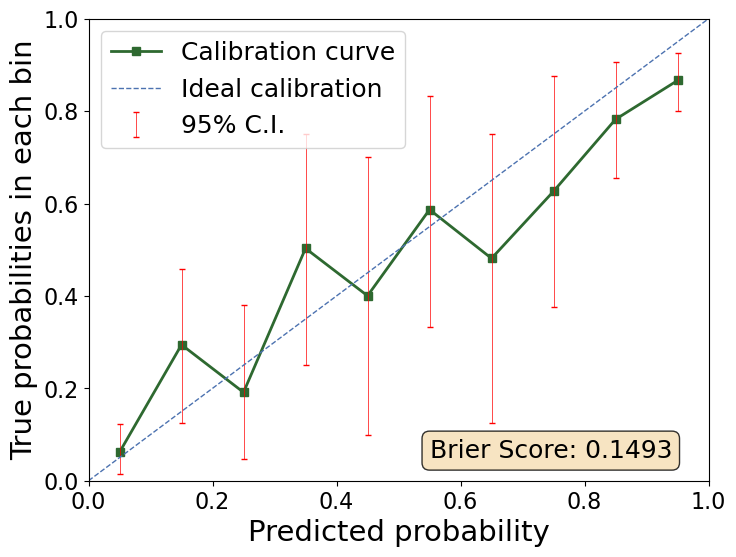

In [18]:
bin_centers, mean_acc, lo_ci, hi_ci = calibration_curve(
    preds, labels,
    n_bins=n_bins,
    n_iterations=1000,
    random_state=42
)

m = compute_metrics(
    y_pred_scores=preds,
    y_true=labels,
    n_bins=n_bins,            
    n_bootstraps=1000,
    random_state=42
)


plot_calibration_curve_with_ci(
    bin_centers, mean_acc, lo_ci, hi_ci,
    ece=m['ECE'],
    brier_score=m['Brier Score']
)

# Plot Missclassification

In [19]:
data_relevant_misclass
#print(data_relevant_misclass['race'].unique()) ['white' 'Non-white' 'Unknown']

,participant_id,gender,age_group,race,pred_score_fusion,true_label
0,NIHNT179KNNF4,Female,60 - 79,white,0.988402,1.0
1,NIHNT179KNNF4,Female,60 - 79,white,0.665972,1.0
2,NIHNT823CHAC3,Female,60 - 79,Non-white,0.976564,0.0
3,NIHNT823CHAC3,Female,60 - 79,Non-white,0.540549,0.0
4,NIHNT823CHAC3,Female,60 - 79,Non-white,0.112835,0.0
...,...,...,...,...,...,...
315,xSKwE2YgQFaXtUTTjbOyFhx3oCm2,Male,60 - 79,white,0.889474,1.0
316,xtsnpDyq8BYQUtRaZjSjSCTGVoe2,Male,40 - 59,white,0.273126,0.0
317,yWXLyTJ9MwUskybFC1AqHA1yoN73,Male,60 - 79,Non-white,0.302878,0.0
318,yxycFfgyJjMYeRRaw9ENTsXeE4H2,Female,40 - 59,white,0.023653,0.0


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def bootstrap_mean_ci(series: pd.Series, n_iterations: int = 1000):
    series = series.dropna().values
    props = []
    for _ in range(n_iterations):
        sample = np.random.choice(series, size=len(series), replace=True)
        props.append(sample.mean())

    props = np.array(props)
    mu = props.mean()
    se = np.sqrt(np.sum((props - mu)**2) / (len(props) - 1))
    ci = (mu - 1.96 * se, mu + 1.96 * se)
    return float(round(mu, 2)), float(round(se, 2)), (float(round(ci[0], 2)), float(round(ci[1], 2)))


def compute_misclassification_summary(df, group_cols, pred_col='pred_score_fusion', true_col='true_label', threshold=0.5):
    df = df.copy()
    df['pred_label'] = (df[pred_col] >= threshold).astype(int)
    df['misclassified'] = (df['pred_label'] != df[true_col]).astype(int)

    summary = {}
    for col in group_cols:
        groups = df[col].dropna().unique()
        group_stats = []
        for group in groups:
            group_df = df[df[col] == group]
            mu, se, (ci_lower, ci_upper) = bootstrap_mean_ci(group_df['misclassified'])
            group_stats.append({
                'group': group,
                'mean': mu,
                'se': se,
                'ci_lower': ci_lower,
                'ci_upper': ci_upper,
                'n_total': len(group_df),
                'n_wrong': int(group_df['misclassified'].sum())
            })
        # Overall stats (optional)
        mu, se, (ci_lower, ci_upper) = bootstrap_mean_ci(df['misclassified'])
        group_stats.append({
            'group': 'all',
            'mean': mu,
            'se': se,
            'ci_lower': ci_lower,
            'ci_upper': ci_upper,
            'n_total': len(df),
            'n_wrong': int(df['misclassified'].sum())
        })
        summary[col] = group_stats
    return summary


def plot_group_summary(
    summary,
    y_scale=(0, 0.7),
    y_scale_name='Misclassification Rate',
    save=False,
    filename='groupwise_misclassification.png'
):
    dims = list(summary.keys())
    dim_names = [d.replace('_', ' ').title() for d in dims]

    # custom_colors = {
    #     'Female': '#bfd3c1',
    #     'Male': '#efc7c2',
    #     'Non-white': '#b388eb',
    #     'white': '#ceb3f2',
    #     'Unknown': '#ceb333',
    #     '20 - 39': '#FFF085',
    #     '40 - 59': '#FCB454',
    #     '60 - 79': '#FF9B17',
    #     '>= 80': '#A86523'
    # }

    custom_colors = {
        'Female': '#1f77b4',
        'Male': '#aec7e8',
        'Non-white': '#ffbb78',
        'white': '#ff7f0e',
        'Unknown': '#b35f00',
        '20 - 39': '#98df8a',
        '40 - 59': '#2ca02c',
        '60 - 79': '#1e7f1e',
        '>= 80': '#0f3b0f'
    }

    include_values = {
        'gender': ['Female', 'Male'],
        'age_group': ['20 - 39', '40 - 59', '60 - 79', '>= 80'],
        'race': ['white', 'Non-white', 'Unknown']
    }

    subcats_list, values_list, errors_list, label_list, count_labels = [], [], [], [], []

    for d in dims:
        stats = summary[d]
        allowed_groups = include_values.get(d, None)

        subs = [
            s for s in stats
            if s['group'] != 'all' and (allowed_groups is None or s['group'] in allowed_groups)
        ]

        if allowed_groups:
            subs = sorted(subs, key=lambda x: allowed_groups.index(x['group']))

        groups = [s['group'] for s in subs]
        subcats_list.append(groups)
        label_list.append(groups)

        vals = [s['mean'] for s in subs]
        errs = [(s['mean'] - s['ci_lower'], s['ci_upper'] - s['mean']) for s in subs]
        values_list.append(vals)
        errors_list.append(np.array(errs).T)

        # Build count labels as "wrong/total"
        count_labels.append([f"{s['n_wrong']}/{s['n_total']}" for s in subs])

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 6))
    x_base = np.arange(len(dims))
    bar_width = 0.25

    positions = []
    for i, (subs, vals, errs, count_strs) in enumerate(zip(subcats_list, values_list, errors_list, count_labels)):
        n = len(subs)
        mid = (n - 1) / 2
        for j, (sub, val, count_text) in enumerate(zip(subs, vals, count_strs)):
            xpos = x_base[i] + (j - mid) * bar_width
            color = custom_colors.get(sub, '#999999')
            ax.bar(xpos, val, width=bar_width, color=color, zorder=1)
            ax.errorbar(xpos, val, yerr=[[errs[0][j]], [errs[1][j]]],
                        fmt='none', ecolor='black', capsize=5, zorder=2, label='95% C.I.')
            positions.append((xpos, sub))

            # Add count label above CI bar
            if i==1 and j==2:
                ax.text(
                    xpos, val + errs[1][j] + 0.05,
                    count_text,
                    ha='center', va='bottom',
                    fontsize=18,
                    bbox=dict(facecolor=color, alpha=0.2, boxstyle='round,pad=0.2', edgecolor='none')
                )
            else:
                ax.text(
                    xpos, val + errs[1][j] + 0.02,
                    count_text,
                    ha='center', va='bottom',
                    fontsize=18,
                    bbox=dict(facecolor=color, alpha=0.2, boxstyle='round,pad=0.2', edgecolor='none')
                )

    # X-labels under bars
    for xpos, label in positions:
        ax.text(
            xpos, 0,
            label,
            ha='center', va='top',
            rotation=20,
            fontsize=18,
            transform=ax.get_xaxis_transform()
        )

    ax.set_xticks(x_base)
    ax.set_xticklabels(dim_names, fontsize=18)
    ax.tick_params(axis='x', which='major', pad=50, top=False, bottom=False) 
    ax.set_xticklabels(['Sex', 'Age Group', 'Race'], fontweight='bold', fontsize=18)
    ax.tick_params(axis='y', labelsize=18)

    ax.set_ylim(y_scale)
    ax.set_xlabel('Demographic Subgroups', labelpad=20, fontsize=22)
    ax.set_ylabel(y_scale_name, fontsize=22)
    plt.tight_layout()

    if save:
        fig.savefig(filename, dpi=800, bbox_inches='tight')
    #plt.legend()
    plt.show()


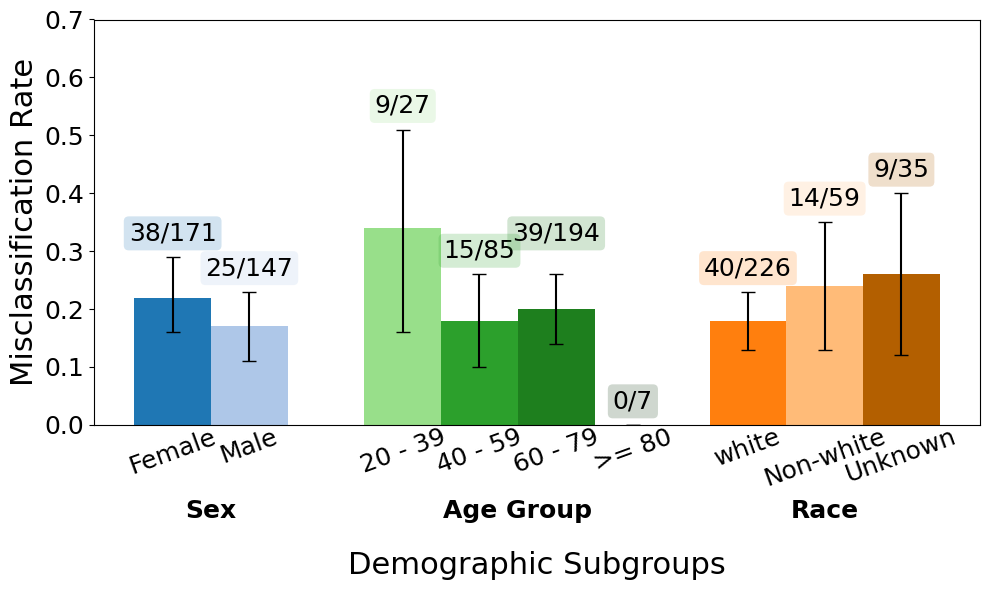

In [21]:
group_cols = ['gender', 'age_group', 'race']
misclassification_summary = compute_misclassification_summary(data_relevant_misclass, group_cols)

plot_group_summary(misclassification_summary, save=True, filename='./plots/figure_2/groupwise_misclassification.png')

# Plot Stage

In [22]:
data_with_stage = data_with_stage[['participant_id', 'pred_score_fusion', 'true_label', 'Stage Label' ]]
data_with_stage.head()

,participant_id,pred_score_fusion,true_label,Stage Label
0,NIHNT179KNNF4,0.988402,1.0,Stage 2
1,NIHNT179KNNF4,0.665972,1.0,Stage 2
2,NIHWK564NAZNZ,0.430305,1.0,Stage 2
3,NIHWK564NAZNZ,0.811272,1.0,Stage 2
4,NIHWK564NAZNZ,0.838528,1.0,Stage 2


In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def bootstrap_mean_ci(series: pd.Series, n_iterations: int = 1000):
    series = series.dropna().values
    props = []
    for _ in range(n_iterations):
        sample = np.random.choice(series, size=len(series), replace=True)
        props.append(sample.mean())

    props = np.array(props)
    mu = props.mean()
    se = np.sqrt(np.sum((props - mu)**2) / (len(props) - 1))
    ci = (mu - 1.96 * se, mu + 1.96 * se)
    return float(round(mu, 2)), float(round(se, 2)), (float(round(ci[0], 2)), float(round(ci[1], 2)))

def compute_stage_accuracy_summary(df, pred_col='pred_score_fusion', true_col='true_label', group_col='Stage Label', threshold=0.5):
    df = df.copy()
    df['pred_label'] = (df[pred_col] >= threshold).astype(int)
    df['correct'] = (df['pred_label'] == df[true_col]).astype(int)

    summary = []
    for stage in sorted(df[group_col].dropna().unique()):
        sub_df = df[df[group_col] == stage]
        acc, se, (ci_lo, ci_hi) = bootstrap_mean_ci(sub_df['correct'])
        summary.append({
            'stage': stage,
            'accuracy': acc,
            'se': se,
            'ci_lower': ci_lo,
            'ci_upper': ci_hi,
            'n_correct': int(sub_df['correct'].sum()),
            'n_total': len(sub_df)
        })
    return summary

def plot_stage_accuracy(summary, y_scale=(0.0, 1.05), save=False, filename='stage_accuracy.png'):
    stages = [s['stage'] for s in summary]
    accs = [s['accuracy'] for s in summary]
    errs = [(s['accuracy'] - s['ci_lower'], s['ci_upper'] - s['accuracy']) for s in summary]
    error_arr = np.array(errs).T
    counts = [f"{s['n_correct']}/{s['n_total']}" for s in summary]

    # counts = [f"{s['n_correct']}/{s['n_total']}" for s in summary]

    fig, ax = plt.subplots(figsize=(8, 5))
    x = np.arange(len(stages))
    bar_width = 0.5
    colors = ['#a6d96a', '#d9d9d9', '#fdae61', '#d7191c']
    #color = '#8cbdd4'

    # Plot bars
    ax.bar(x, accs, yerr=error_arr, capsize=5, color=colors, width=bar_width)

    # Sample size text above bars
    for i, (val, err, label) in enumerate(zip(accs, error_arr[1], counts)):
        if i==2:
            ax.text(x[i] + 0.25, val + err - 0.05, label, ha='center', va='bottom', fontsize=18,
                bbox=dict(facecolor=colors[i], alpha=0.2, boxstyle='round,pad=0.2', edgecolor='none'))
        else:
            ax.text(x[i] + 0.25, val + err - 0.15, label, ha='center', va='bottom', fontsize=18,
                bbox=dict(facecolor=colors[i], alpha=0.2, boxstyle='round,pad=0.2', edgecolor='none'))

    ax.set_xticks(x)
    ax.set_xticklabels(stages, fontsize=18)
    ax.tick_params(axis='y', labelsize=18)
    ax.set_ylim(y_scale)
    ax.set_ylabel('Accuracy', fontsize=22)
    ax.set_xlabel('PD Stage (Hoehn and Yahr scale)', labelpad=10, fontsize=22)
    # ax.set_title('Classification Accuracy by Stage Label')
    plt.tight_layout()

    if save:
        fig.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()


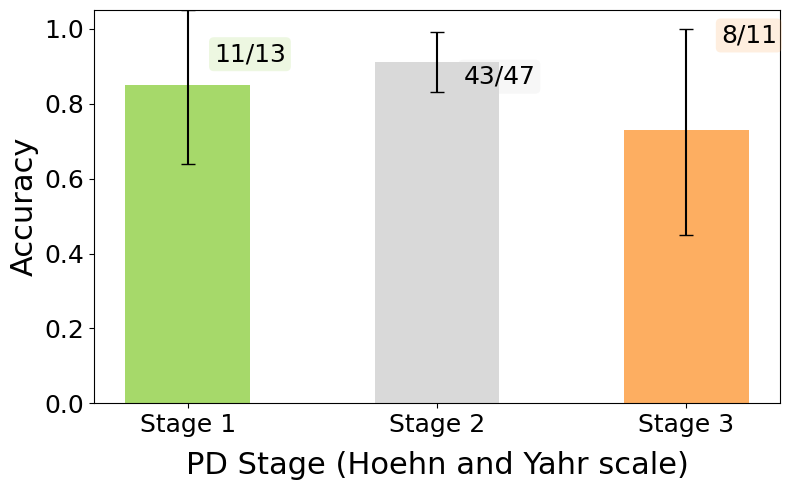

In [24]:
stage_summary = compute_stage_accuracy_summary(data_with_stage)
plot_stage_accuracy(stage_summary, save=True, filename='./plots/figure_2/stage_accuracy.png')

In [25]:
stage_summary

[{'stage': 'Stage 1',
  'accuracy': 0.85,
  'se': 0.1,
  'ci_lower': 0.64,
  'ci_upper': 1.05,
  'n_correct': 11,
  'n_total': 13},
 {'stage': 'Stage 2',
  'accuracy': 0.91,
  'se': 0.04,
  'ci_lower': 0.83,
  'ci_upper': 0.99,
  'n_correct': 43,
  'n_total': 47},
 {'stage': 'Stage 3',
  'accuracy': 0.73,
  'se': 0.14,
  'ci_lower': 0.45,
  'ci_upper': 1.0,
  'n_correct': 8,
  'n_total': 11}]

In [26]:
# add a new column diagnosis_status = self-reported if protocol ==  ParkTest else validated
data['diagnosis_status'] = data['protocol'].map({'ParkTest': 'self-reported'}).fillna('validated')
data['diagnosis_status'].value_counts()

diagnosis_status
validated        257
self-reported     63
Name: count, dtype: int64

In [27]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score

# -----------------------------
# Config
# -----------------------------
GROUP_COL   = 'diagnosis_status'      # 'self-reported' vs 'validated'
Y_COL       = 'true_label'
SCORE_COL   = 'pred_score_fusion'
UNCERT_COL  = 'uncertain_flag'        # optional
MISCL_COL   = 'misclassified_fusion'  # optional accuracy source

EXCLUDE_UNCERTAIN        = False   # set True to drop uncertain cases
USE_MISCLASSIFIED_COLUMN = False   # set True to compute accuracy from misclassified_fusion
THRESHOLD = 0.5                   # only used if not using MISCL_COL

N_BOOT = 2000
N_PERM = 5000
RNG = np.random.default_rng(7)

# -----------------------------
# Prep
# -----------------------------
df = data.copy()

if EXCLUDE_UNCERTAIN and UNCERT_COL in df.columns:
    df = df[df[UNCERT_COL] == 0].copy()

df = df.dropna(subset=[Y_COL, SCORE_COL, GROUP_COL])

df[Y_COL] = df[Y_COL].astype(int)
df[SCORE_COL] = df[SCORE_COL].astype(float)

if USE_MISCLASSIFIED_COLUMN and MISCL_COL in df.columns:
    # accuracy = 1 - mean(misclassified)
    df['_pred_bin'] = (1 - df[MISCL_COL].astype(int)).where(True, np.nan)  # not used directly
else:
    df['_pred_bin'] = (df[SCORE_COL] >= THRESHOLD).astype(int)

# -----------------------------
# Metric helpers
# -----------------------------
def acc_of(d):
    if USE_MISCLASSIFIED_COLUMN and MISCL_COL in d.columns:
        return 1.0 - d[MISCL_COL].astype(int).mean()
    return (d['_pred_bin'].to_numpy() == d[Y_COL].to_numpy()).mean()

def auc_of(d):
    y = d[Y_COL].to_numpy()
    s = d[SCORE_COL].to_numpy()
    return roc_auc_score(y, s) if np.unique(y).size == 2 else np.nan

def bootstrap_ci(d, func, n=N_BOOT):
    vals = []
    nrows = len(d)
    idx = np.arange(nrows)
    for _ in range(n):
        samp = RNG.choice(idx, size=nrows, replace=True)
        vals.append(func(d.iloc[samp]))
    vals = np.array(vals, dtype=float)
    lo, hi = np.nanpercentile(vals, [2.5, 97.5])
    return (np.nanmean(vals), lo, hi), vals

# -----------------------------
# Per-group metrics + CIs
# -----------------------------
groups = dict(tuple(df.groupby(GROUP_COL)))
A = groups.get('self-reported')
B = groups.get('validated')
if A is None or B is None:
    raise ValueError("Need both 'self-reported' and 'validated' in diagnosis_status.")

accA, aucA = acc_of(A), auc_of(A)
accB, aucB = acc_of(B), auc_of(B)

(accA_ci, accA_samps) = bootstrap_ci(A, acc_of)
(accB_ci, accB_samps) = bootstrap_ci(B, acc_of)
(aucA_ci, aucA_samps) = bootstrap_ci(A, auc_of)
(aucB_ci, aucB_samps) = bootstrap_ci(B, auc_of)

# CIs for differences (A - B)
def diff_ci(sa, sb):
    n = min(len(sa), len(sb))
    diffs = sa[:n] - sb[:n]
    lo, hi = np.nanpercentile(diffs[~np.isnan(diffs)], [2.5, 97.5])
    return float(np.nanmean(diffs)), float(lo), float(hi), diffs

acc_diff, acc_lo, acc_hi, acc_diff_samps = diff_ci(accA_samps, accB_samps)
auc_diff, auc_lo, auc_hi, auc_diff_samps = diff_ci(aucA_samps, aucB_samps)

# -----------------------------
# Permutation p-values (two-sided)
# -----------------------------
def perm_p_two_sided(df_all, metric='accuracy', n_perm=N_PERM):
    y   = df_all[Y_COL].to_numpy()
    s   = df_all[SCORE_COL].to_numpy()
    yhat= df_all['_pred_bin'].to_numpy()
    g   = df_all[GROUP_COL].to_numpy()

    def stat(maskA, maskB):
        if metric == 'accuracy':
            return (yhat[maskA] == y[maskA]).mean() - (yhat[maskB] == y[maskB]).mean()
        else:  # 'auroc'
            okA = np.unique(y[maskA]).size == 2
            okB = np.unique(y[maskB]).size == 2
            if not (okA and okB): return np.nan
            return roc_auc_score(y[maskA], s[maskA]) - roc_auc_score(y[maskB], s[maskB])

    maskA = (g == 'self-reported')
    maskB = (g == 'validated')
    obs = stat(maskA, maskB)

    diffs = []
    idx = np.arange(len(g))
    for _ in range(n_perm):
        perm = RNG.permutation(idx)
        gp = g[perm]
        d = stat(gp == 'self-reported', gp == 'validated')
        if not np.isnan(d):
            diffs.append(d)
    diffs = np.array(diffs, dtype=float)
    if diffs.size == 0:
        return obs, np.nan
    p = (np.sum(np.abs(diffs) >= np.abs(obs)) + 1) / (diffs.size + 1)
    return obs, p

acc_obs, p_acc = perm_p_two_sided(df, 'accuracy')
auc_obs, p_auc = perm_p_two_sided(df, 'auroc')

# -----------------------------
# Output tables
# -----------------------------
summary = pd.DataFrame({
    'group': ['self-reported','validated'],
    'n': [len(A), len(B)],
    'Accuracy': [accA, accB],
    'Accuracy_CI95': [f"[{accA_ci[1]:.3f}, {accA_ci[2]:.3f}]",
                      f"[{accB_ci[1]:.3f}, {accB_ci[2]:.3f}]"],
    'AUROC': [aucA, aucB],
    'AUROC_CI95': [f"[{aucA_ci[1]:.3f}, {aucA_ci[2]:.3f}]",
                   f"[{aucB_ci[1]:.3f}, {aucB_ci[2]:.3f}]"],
})

diffs = pd.DataFrame({
    'comparison': ['self-reported - validated','self-reported - validated'],
    'metric': ['Accuracy','AUROC'],
    'diff_obs': [acc_diff, auc_diff],
    'CI95': [f"[{acc_lo:.3f}, {acc_hi:.3f}]", f"[{auc_lo:.3f}, {auc_hi:.3f}]"],
    'p_value_perm': [p_acc, p_auc],
})

print("\nPer-group metrics:")
print(summary.to_string(index=False))
print("\nBetween-group differences (A - B):")
print(diffs.to_string(index=False))



Per-group metrics:
        group   n  Accuracy  Accuracy_CI95    AUROC     AUROC_CI95
self-reported  63  0.777778 [0.667, 0.873] 0.829218 [0.670, 0.951]
    validated 257  0.809339 [0.759, 0.856] 0.856746 [0.804, 0.904]

Between-group differences (A - B):
               comparison   metric  diff_obs            CI95  p_value_perm
self-reported - validated Accuracy -0.030843 [-0.147, 0.087]      0.599880
self-reported - validated    AUROC -0.029848 [-0.195, 0.103]      0.597281


In [28]:
import numpy as np
import pandas as pd
from scipy.stats import norm

# --- config (your columns) ---
GROUP   = 'diagnosis_status'     # 'self-reported' vs 'validated'
Y_COL   = 'true_label'
SCORE   = 'pred_score_fusion'
THRESH  = 0.5                    # for accuracy

df = data.copy()
df = df.dropna(subset=[GROUP, Y_COL, SCORE]).copy()
df[Y_COL] = df[Y_COL].astype(int)
df[SCORE] = df[SCORE].astype(float)
df['_pred'] = (df[SCORE] >= THRESH).astype(int)

A = df[df[GROUP] == 'self-reported'].copy()
B = df[df[GROUP] == 'validated'].copy()
if A.empty or B.empty:
    raise ValueError("Need both 'self-reported' and 'validated' groups present.")

# ---------- helpers ----------
def two_prop_z(x1, n1, x2, n2, continuity=False):
    p1, p2 = x1/n1, x2/n2
    p_pool = (x1 + x2) / (n1 + n2)
    se = np.sqrt(p_pool * (1 - p_pool) * (1/n1 + 1/n2))
    if se == 0:
        return np.nan, np.nan
    if continuity:
        # basic continuity correction
        delta = abs(p1 - p2) - 0.5*(1/n1 + 1/n2)
        z = np.sign(p1 - p2) * (delta / se)
    else:
        z = (p1 - p2) / se
    p = 2 * (1 - norm.cdf(abs(z)))
    return z, p

def wilson_ci(x, n, alpha=0.05):
    if n == 0:
        return (np.nan, np.nan)
    z = norm.ppf(1 - alpha/2)
    p = x / n
    denom = 1 + z*z/n
    centre = p + z*z/(2*n)
    pm = z*np.sqrt((p*(1-p) + z*z/(4*n))/n)
    lo = (centre - pm)/denom
    hi = (centre + pm)/denom
    return lo, hi

def auc_as_pairs(y, s):
    """Return (successes, total_pairs, strict_conc, strict_disc, auc) where
       successes = conc + 0.5*ties, total_pairs = m*n."""
    y = np.asarray(y).astype(int)
    s = np.asarray(s).astype(float)
    pos = s[y == 1]
    neg = s[y == 0]
    m, n = len(pos), len(neg)
    if m == 0 or n == 0:
        return np.nan, np.nan, 0, 0, np.nan
    # pairwise compare (OK for your sizes)
    # broadcasting: pos[:,None] vs neg[None,:]
    gt = (pos[:, None] >  neg[None, :]).sum()
    lt = (pos[:, None] <  neg[None, :]).sum()
    eq = (pos[:, None] == neg[None, :]).sum()
    successes = gt + 0.5*eq
    total = m * n
    auc = successes / total
    return successes, total, gt, lt, auc

# ---------- Accuracy: two-proportion z ----------
nA, nB = len(A), len(B)
xA_acc = int((A['_pred'].to_numpy() == A[Y_COL].to_numpy()).sum())
xB_acc = int((B['_pred'].to_numpy() == B[Y_COL].to_numpy()).sum())
p1_acc, p2_acc = xA_acc/nA, xB_acc/nB
acc_z, acc_p = two_prop_z(xA_acc, nA, xB_acc, nB, continuity=False)
acc_ciA = wilson_ci(xA_acc, nA)
acc_ciB = wilson_ci(xB_acc, nB)
acc_ok = min(xA_acc, nA - xA_acc, xB_acc, nB - xB_acc) >= 5

# ---------- AUROC as proportion of concordant pairs: two-proportion z ----------
succA, NpairsA, gtA, ltA, aucA = auc_as_pairs(A[Y_COL].values, A[SCORE].values)
succB, NpairsB, gtB, ltB, aucB = auc_as_pairs(B[Y_COL].values, B[SCORE].values)

if not (np.isfinite(NpairsA) and np.isfinite(NpairsB) and NpairsA > 0 and NpairsB > 0):
    auc_z, auc_p = np.nan, np.nan
    auc_ciA = (np.nan, np.nan)
    auc_ciB = (np.nan, np.nan)
    auc_ok = False
else:
    # two-proportion z on pairwise "success" proportions
    auc_z, auc_p = two_prop_z(succA, NpairsA, succB, NpairsB, continuity=False)
    auc_ciA = wilson_ci(succA, NpairsA)
    auc_ciB = wilson_ci(succB, NpairsB)
    # sample-size check using STRICT conc/discord counts (ties excluded)
    auc_ok = min(gtA, ltA, gtB, ltB) >= 5

# ---------- Print summary ----------
print("ACCURACY (two-proportion z):")
print(f"  self-reported: {p1_acc:.3f} ({xA_acc}/{nA}), 95% CI {acc_ciA[0]:.3f}-{acc_ciA[1]:.3f}")
print(f"  validated    : {p2_acc:.3f} ({xB_acc}/{nB}), 95% CI {acc_ciB[0]:.3f}-{acc_ciB[1]:.3f}")
print(f"  diff (p1-p2) = {p1_acc - p2_acc:.3f}, z={acc_z:.3f}, p={acc_p:.3f}"
      + ("" if acc_ok else "  [warning: small cell counts—normal approx may be unreliable]"))

print("\nAUROC as proportion of concordant pairs (two-proportion z):")
print(f"  self-reported: AUC={aucA:.3f}, 95% CI {auc_ciA[0]:.3f}-{auc_ciA[1]:.3f} "
      f"(pairs={int(NpairsA)}, strict conc/disc={gtA}/{ltA})")
print(f"  validated    : AUC={aucB:.3f}, 95% CI {auc_ciB[0]:.3f}-{auc_ciB[1]:.3f} "
      f"(pairs={int(NpairsB)}, strict conc/disc={gtB}/{ltB})")
print(f"  diff (AUC_A - AUC_B) = {aucA - aucB:.3f}, z={auc_z:.3f}, p={auc_p:.3f}"
      + ("" if auc_ok else "  [warning: few concordant/discordant pairs—normal approx may be unreliable]"))


ACCURACY (two-proportion z):
  self-reported: 0.778 (49/63), 95% CI 0.661-0.863
  validated    : 0.809 (208/257), 95% CI 0.757-0.853
  diff (p1-p2) = -0.032, z=-0.565, p=0.572

AUROC as proportion of concordant pairs (two-proportion z):
  self-reported: AUC=0.829, 95% CI 0.793-0.860 (pairs=486, strict conc/disc=403/83)
  validated    : AUC=0.857, 95% CI 0.851-0.862 (pairs=15106, strict conc/disc=12942/2164)
  diff (AUC_A - AUC_B) = -0.028, z=-1.701, p=0.089


In [29]:
import pandas as pd 
import numpy as np

In [30]:
df_test_results = pd.read_csv('../../data/test_data_big.csv')
df_test_results['pred_park'] = (df_test_results['pred_score_fusion'] >= 0.5).astype(int)


In [31]:
relevant_columns = ['participant_id', 'true_label', 'pred_park', 'pred_score_fusion', 'uncertain_flag',
                    'pred_std_fusion', 'test_split', 'misclassified_fusion']

df_test_results_certainity = df_test_results[relevant_columns]
df_test_results_certainity

,participant_id,true_label,pred_park,pred_score_fusion,uncertain_flag,pred_std_fusion,test_split,misclassified_fusion
0,NIHNT179KNNF4,1.0,1,0.988402,False,0.001296,global,False
1,NIHNT179KNNF4,1.0,1,0.665972,False,0.032354,global,False
2,NIHNT823CHAC3,0.0,1,0.976564,False,0.003919,global,True
3,NIHNT823CHAC3,0.0,1,0.540549,False,0.023983,global,True
4,NIHNT823CHAC3,0.0,0,0.112835,False,0.013366,global,False
...,...,...,...,...,...,...,...,...
315,xSKwE2YgQFaXtUTTjbOyFhx3oCm2,1.0,1,0.889474,False,0.018489,validation_2,False
316,xtsnpDyq8BYQUtRaZjSjSCTGVoe2,0.0,0,0.273126,False,0.037375,validation_2,False
317,yWXLyTJ9MwUskybFC1AqHA1yoN73,0.0,0,0.302878,False,0.043463,validation_2,False
318,yxycFfgyJjMYeRRaw9ENTsXeE4H2,0.0,0,0.023653,False,0.011292,validation_2,False


In [32]:
# set bins = [0, 0.015, 0.030, 0.045, 0.045+]
bins = [0, 0.015, 0.03, 0.045, np.inf]
labels = ['0-0.015', '0.015-0.030', '0.030-0.045', '0.045+']
df_test_results_certainity['std_bin'] = pd.cut(df_test_results_certainity['pred_std_fusion'], bins=bins, labels=labels, right=False)

# set the above labels to the std_bin categories
bin_label_map = {
    '0-0.015': 'Low (n=194)',
    '0.015-0.030': 'Fair (n=71)',
    '0.030-0.045': 'Substantial (n=34)',
    '0.045+': 'High (n=21)'
}

df_test_results_certainity['std_bin'] = df_test_results_certainity['std_bin'].map(bin_label_map)


df_test_results_certainity['std_bin'].value_counts().sort_index()


/tmp/ipykernel_3017997/3143443911.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_results_certainity['std_bin'] = pd.cut(df_test_results_certainity['pred_std_fusion'], bins=bins, labels=labels, right=False)
/tmp/ipykernel_3017997/3143443911.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_results_certainity['std_bin'] = df_test_results_certainity['std_bin'].map(bin_label_map)


std_bin
Low (n=194)           194
Fair (n=71)            71
Substantial (n=34)     34
High (n=21)            21
Name: count, dtype: int64

In [33]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.utils import resample

def calculate_metrics_bootstrapped(true_labels, pred_labels, n_bootstraps=100):
    rng = np.random.RandomState(seed=42)

    # Convert to numpy arrays
    true_labels = np.array(true_labels)
    pred_labels = np.array(pred_labels)

    # Lists to store bootstrap results
    boot_auroc, boot_acc, boot_ppv, boot_npv, boot_sens, boot_spec, boot_f1 = [], [], [], [], [], [], []

    boot_count = 0
    while boot_count < n_bootstraps:
        # Sample indices with replacement
        indices = rng.choice(len(true_labels), size=len(true_labels), replace=True)
        
        # Sample labels
        y_true = true_labels[indices]
        y_pred = pred_labels[indices]

        try:
            auroc = roc_auc_score(y_true, y_pred)
        except ValueError:
            continue  # Retry this bootstrap

        acc = accuracy_score(y_true, y_pred)

        try:
            tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
        except ValueError:
            continue  # Retry this bootstrap

        # Compute metrics safely
        ppv = tp / (tp + fp) if (tp + fp) > 0 else np.nan
        npv = tn / (tn + fn) if (tn + fn) > 0 else np.nan
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else np.nan
        specificity = tn / (tn + fp) if (tn + fp) > 0 else np.nan
        f1_score = 2 * (ppv * sensitivity) / (ppv + sensitivity) if (ppv + sensitivity) > 0 else np.nan

        if np.isnan([ppv, npv, sensitivity, specificity, f1_score]).any():
            continue  # Retry this bootstrap

        # Append to result lists
        boot_auroc.append(auroc)
        boot_acc.append(acc)
        boot_ppv.append(ppv)
        boot_npv.append(npv)
        boot_sens.append(sensitivity)
        boot_spec.append(specificity)
        boot_f1.append(f1_score)

        boot_count += 1  # only increment if the sample is valid

    # Aggregate results
    bootstrap_results = {
        'AUROC': boot_auroc,
        'Accuracy': boot_acc,
        'PPV': boot_ppv,
        'NPV': boot_npv,
        'Sensitivity': boot_sens,
        'Specificity': boot_spec,
        'F1 Score': boot_f1
    }

    # Summary with mean ± 95% CI
    summary = {}
    for metric, values in bootstrap_results.items():
        mean_val = np.nanmean(values)
        lower_ci = np.nanpercentile(values, 2.5)
        upper_ci = np.nanpercentile(values, 97.5)
        margin = (upper_ci - lower_ci) / 2
        summary[metric] = f"{round(mean_val * 100, 1)} ± {round(margin * 100, 1)}"

    summary_df = pd.DataFrame.from_dict(summary, orient='index', columns=['Mean ± 95% CI'])
    return summary_df, bootstrap_results


In [34]:
# now we can calculate metrics for each bin
results_by_std_bin = {}

labels = ['Low (n=194)', 'Fair (n=71)', 'Substantial (n=34)', 'High (n=21)']


for bin_label in labels:
    subset = df_test_results_certainity[df_test_results_certainity['std_bin'] == bin_label]
    true_labels = np.asarray(subset['true_label'])
    pred_labels = np.asarray(subset['pred_park'])
    
    if len(true_labels) < 10:
        print(f"Skipping bin {bin_label} due to insufficient samples ({len(true_labels)} samples).")
        continue
    
    summary_df, bootstrap_results = calculate_metrics_bootstrapped(true_labels, pred_labels)
    results_by_std_bin[bin_label] = {
        'summary': summary_df,
        'bootstraps': bootstrap_results,
        'n_samples': len(true_labels)
    }
    
rows = []
for bin_label, result in results_by_std_bin.items():
    summary = result["summary"]  # index: metrics; col: "Mean ± 95% CI"
    for metric in summary.index:
        s = str(summary.loc[metric, "Mean ± 95% CI"])  # e.g., "83.4 ± 3.2" or "83.4% ± 3.2%"
        parts = [p.replace("%", "").strip() for p in s.split("±")]
        if len(parts) != 2:
            continue
        try:
            mean = float(parts[0]) / 100.0
            ci   = float(parts[1]) / 100.0
        except ValueError:
            continue
        rows.append({"Std Bin": bin_label, "Metric": metric, "Mean": mean, "CI": ci})

plot_df = pd.DataFrame(rows)

plot_df

,Std Bin,Metric,Mean,CI
0,Low (n=194),AUROC,0.860,0.050
1,Low (n=194),Accuracy,0.874,0.047
2,Low (n=194),PPV,0.850,0.070
3,Low (n=194),NPV,0.916,0.068
4,Low (n=194),Sensitivity,0.949,0.039
5,Low (n=194),Specificity,0.771,0.093
6,Low (n=194),F1 Score,0.896,0.038
7,Fair (n=71),AUROC,0.718,0.105
8,Fair (n=71),Accuracy,0.718,0.106
9,Fair (n=71),PPV,0.711,0.147


In [35]:
# set a column named uncertainty_level in df_test_results_certainity equal to the std_bin column
df_test_results_certainity['uncertainty_level'] = df_test_results_certainity['std_bin']
df_test_results_certainity['uncertainty_level'].value_counts()

/tmp/ipykernel_3017997/373007250.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_results_certainity['uncertainty_level'] = df_test_results_certainity['std_bin']


uncertainty_level
Low (n=194)           194
Fair (n=71)            71
Substantial (n=34)     34
High (n=21)            21
Name: count, dtype: int64

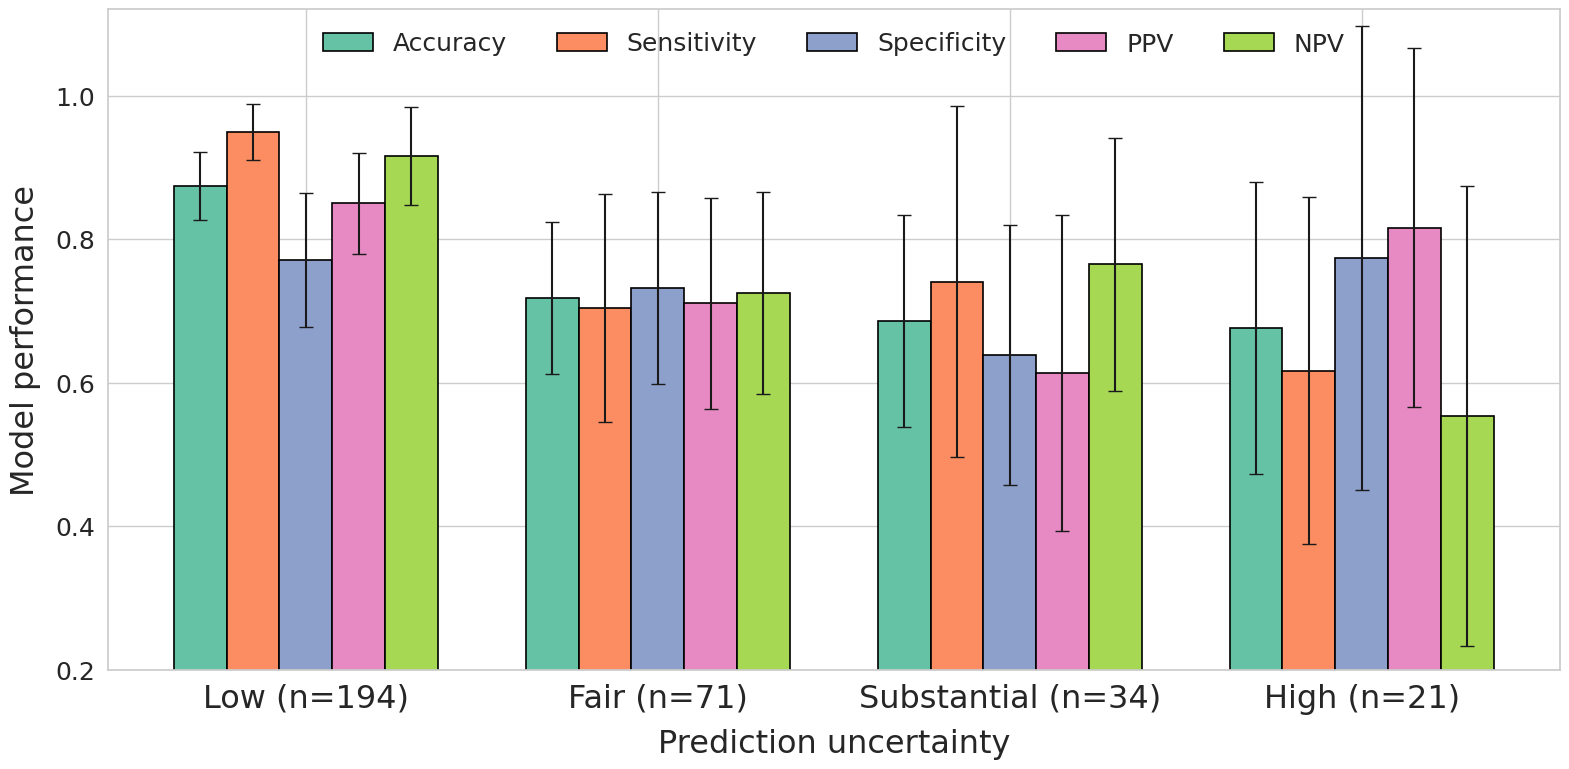

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# --- Assuming plot_df already exists with columns ['Std Bin','Metric','Mean','CI'] ---

plt.figure(figsize=(16, 8))
sns.set(style="whitegrid", font_scale=1.4)  # scale base font sizes

metrics_to_plot = ['Accuracy', 'Sensitivity', 'Specificity', 'PPV', 'NPV']
bar_width = 0.15
x = np.arange(len(plot_df['Std Bin'].unique()))
# labels = plot_df['Std Bin'].unique()
labels = ['Low (n=194)', 'Fair (n=71)', 'Substantial (n=34)', 'High (n=21)']



# Assign consistent colors
colors = sns.color_palette("Set2", len(metrics_to_plot))

for i, metric in enumerate(metrics_to_plot):
    subset = plot_df[plot_df['Metric'] == metric]
    bars = plt.bar(
        x + i * bar_width,
        subset['Mean'],
        yerr=subset['CI'],
        width=bar_width,
        label=metric,
        capsize=5,
        color=colors[i],
        edgecolor="black",
        linewidth=1.2
    )
    # Add labels above upper CI
    # for j, (mean, ci) in enumerate(zip(subset['Mean'], subset['CI'])):
    #     top = mean + ci
    #     plt.text(
    #         x[j] + i * bar_width,
    #         top + 0.02,   # slightly larger offset
    #         f"{mean*100:.1f}%",
    #         ha='center', va='bottom',
    #         fontsize=14
    #     )

# Formatting
plt.ylim(0.2, 1.12)
plt.xlabel("Prediction uncertainty", fontsize=23, labelpad=10)
plt.ylabel("Model performance", fontsize=23, labelpad=10)
# plt.title("Model performance by prediction uncertainty", fontsize=18, weight="bold", pad=15)

plt.xticks(x + bar_width * (len(metrics_to_plot) - 1) / 2, labels, fontsize=23)
plt.yticks(fontsize=18)

plt.legend(
    # title="Performance Metrics",
    # bbox_to_anchor=(0.5, 1),
    loc="upper center",
    ncol=len(metrics_to_plot),
    frameon=False,
    fontsize=18,
    title_fontsize=14
)

plt.tight_layout()
plt.savefig("plots/figure_2/uncertainty_metrics_bars_no_pct.png", dpi=600, bbox_inches="tight")
plt.show()


In [37]:
# we bucketize rows based on pred_score_fusion with 0.1 increments
# we calcualte the level of uncertainty in each bucket

df_test_results_certainity['score_bin'] = pd.cut(df_test_results_certainity['pred_score_fusion'], 
                                                bins=np.arange(0, 1.1, 0.1), 
                                                labels=[f"{i/10:.1f}-{(i+1)/10:.1f}" for i in range(10)],
                                                right=False)
df_test_results_certainity['score_bin'].value_counts().sort_index()

# check count of uncertainty level in each bucket
uncertainty_distribution = df_test_results_certainity.groupby(['score_bin', 'std_bin']).size().unstack(fill_value=0)
uncertainty_distribution

/tmp/ipykernel_3017997/2407907077.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_results_certainity['score_bin'] = pd.cut(df_test_results_certainity['pred_score_fusion'],
/tmp/ipykernel_3017997/2407907077.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  uncertainty_distribution = df_test_results_certainity.groupby(['score_bin', 'std_bin']).size().unstack(fill_value=0)


std_bin,Low (n=194),Fair (n=71),Substantial (n=34),High (n=21)
score_bin,,,,
0.0-0.1,58,6,1,0
0.1-0.2,10,10,3,1
0.2-0.3,1,12,7,1
0.3-0.4,0,5,4,3
0.4-0.5,0,3,1,6
0.5-0.6,0,4,5,3
0.6-0.7,0,3,3,2
0.7-0.8,1,7,4,4
0.8-0.9,11,14,6,1


/tmp/ipykernel_3017997/3943125721.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_percent["score_bin"], rotation=45, fontsize=23)


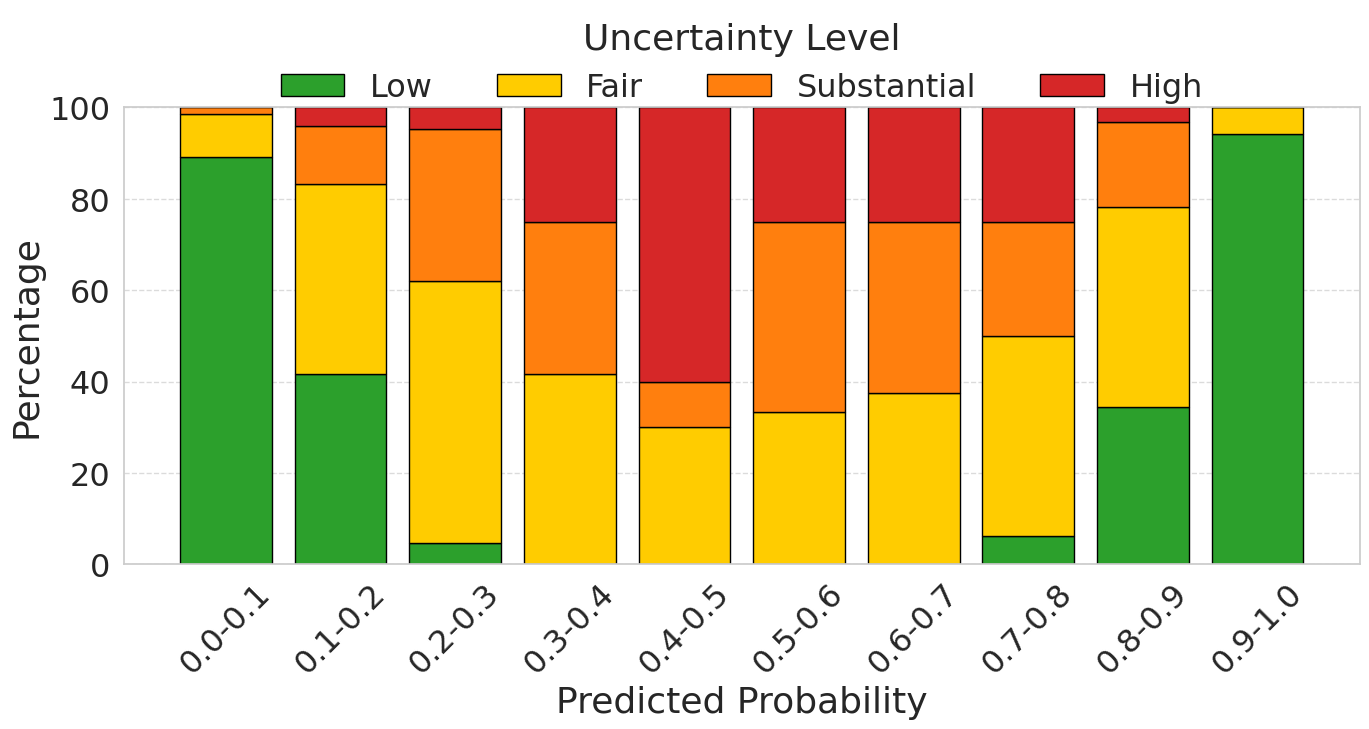

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

# Data provided
data = {
    "score_bin": ["0.0-0.1","0.1-0.2","0.2-0.3","0.3-0.4","0.4-0.5",
                  "0.5-0.6","0.6-0.7","0.7-0.8","0.8-0.9","0.9-1.0"],
    "Low": [58,10,1,0,0,0,0,1,11,113],
    "Fair": [6,10,12,5,3,4,3,7,14,7],
    "Substantial": [1,3,7,4,1,5,3,4,6,0],
    "High": [0,1,1,3,6,3,2,4,1,0]
}

# Create DataFrame
df = pd.DataFrame(data)

# Normalize counts to percentages row-wise
df_percent = df.copy()
categories = ["Low", "Fair", "Substantial", "High"]
df_percent[categories] = df_percent[categories].div(df_percent[categories].sum(axis=1), axis=0) * 100

# Colors with increasing intensity palette (green → yellow → orange → red)
colors = {
    "Low": "#2ca02c",          # medium green
    "Fair": "#ffcc00",         # golden yellow
    "Substantial": "#ff7f0e",  # bright orange
    "High": "#d62728"          # strong red
}

# Plotting
fig, ax = plt.subplots(figsize=(14,8))

bottom = None
for category in categories:
    bars = ax.bar(df_percent["score_bin"], df_percent[category],
                  bottom=bottom, color=colors[category], edgecolor="black",
                  label=category)
    # Add percentage labels inside segments if large enough
    # for bar, val in zip(bars, df_percent[category]):
    #     if val > 5:  # label only if >5%
    #         ax.text(bar.get_x() + bar.get_width()/2,
    #                 bar.get_y() + bar.get_height()/2,
    #                 f"{val:.0f}%", ha="center", va="center", fontsize=14, color="black")
    if bottom is None:
        bottom = df_percent[category].copy()
    else:
        bottom += df_percent[category]

# Style
ax.set_xlabel("Predicted Probability", fontsize=26)
ax.set_ylabel("Percentage", fontsize=26)
ax.set_ylim(0, 100)
ax.set_xticklabels(df_percent["score_bin"], rotation=45, fontsize=23)
ax.tick_params(axis="y", labelsize=23)
ax.grid(axis="y", linestyle="--", alpha=0.7)

# Legend above plot
ax.legend(title="Uncertainty Level", fontsize=23, title_fontsize=26,
          ncol=4, bbox_to_anchor=(0.5, 1.25), loc="upper center", frameon=False)

# Remove title for cleaner look
ax.set_title("")

plt.tight_layout()
plt.savefig("plots/figure_2/uncertainty_distribution.png", dpi=600)
plt.show()
